In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from time import time
import sys
sys.path.append('/Users/rossg/Work/nanoparticles/Analysis')
from AnalysisTools import *
import mdtraj as md
warnings.filterwarnings('ignore', category=DeprecationWarning, message='.*use @default decorator instead.*')
from mdtraj.geometry.sasa import _ATOMIC_RADII
# Below are taken from Bondi 1964, whereas the MdTraj defaults are taken from Gromacs radii.
_ATOMIC_RADII['Cl'] = 0.175
_ATOMIC_RADII['Br'] = 0.187
_ATOMIC_RADII['I'] = 0.204

In [40]:
# Nice colours, taken on 26th Nov 2015 from:
#http://tableaufriction.blogspot.co.uk/2012/11/finally-you-can-use-tableau-data-colors.html

# These are the "Tableau" colors as RGB. I've chosen my faves. 
# In order: blue, green, purple, orange, yellow. Hopefully a good compromise for colour-blind people.
tableau4 = [(31, 119, 180),(44, 160, 44),(148,103,189),(255, 127, 14),(188,189,34)]
tableau4_light = [(174,199,232),(152,223,138),(197,176,213),(255,187,120)]

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts. 
for i in range(len(tableau4)):    
    r, g, b = tableau4[i]    
    tableau4[i] = (r / 255., g / 255., b / 255.)
    
for i in range(len(tableau4_light)):    
    r, g, b = tableau4_light[i]    
    tableau4_light[i] = (r / 255., g / 255., b / 255.)  

# Surface area of all molecules
Nanoparticle formed in implicit solvent, then solvated in explicit solvent. 
* Number of drug molecules = 50
* Number of dye molecules = 20
* water model = TIP3P
* Box dimensions set so that water was at least 10 Angs from edge of nanoparticle

In [3]:
true_nanos =  ['3t','4r','6s','9t','10v']
false_nanos = ['1e','2m','5s','7t','8t']
nanos = true_nanos + false_nanos
mols = ['LIG','DYE']

In [4]:
for lig in nanos:
    # Load trajectory
    folder = '/Users/rossg/Work/nanoparticles/NewExplicit/Production/' + lig + '/'
    traj  = md.load(folder+'traj_centered.dcd',top=folder+'equil.pdb')
    
    # Find the atom ids of the drug and dye
    atmids = [atms.index for atms in traj.topology.atoms if atms.residue.name in mols]
    traj_slice = traj.atom_slice(atmids,inplace=True)
    
    # Calculate the solvent accessible surface area
    sasa = md.shrake_rupley(traj_slice,mode = "residue")
    total_sasa = sasa.sum(axis=1)
    
    # Plot and save
    time = (np.arange(len(total_sasa))+1)*100000*0.002/1000     # Time in nanoseconds: 'nsteps_per_frame*time_step(ps)/num_ps_in_ns
    plt.clf()
    plt.plot(time,total_sasa,color='k',linewidth=3)
    plt.xlabel('Time (ns)',size=16)
    plt.ylabel('Total SASA (nm)^2', size=16)
    if lig in true_nanos:
        plt.savefig('SASA_true_' + lig + '.png', format='png')
    else:
        plt.savefig('SASA_false_' + lig + '.png', format='png')

# Internal distribution of molecules

In [12]:
true_nanos =  ['3t','4r','6s','9t','10v']
false_nanos = ['1e','2m','5s','7t','8t']
nanos = true_nanos + false_nanos
mols = ['LIG','DYE']

In [4]:
mols = ['LIG','DYE']
for lig in nanos:
    # Load trajectory
    folder = '/Users/rossg/Work/nanoparticles/NewExplicit/Production/' + lig + '/'
    traj  = md.load(folder+'traj_centered.dcd',top=folder+'equil.pdb')
    
    # Find the atom ids of the drug and dye
    nanoids = [atms.index for atms in traj.topology.atoms if atms.residue.name in mols]
    dyeids = [atms.index for atms in traj.topology.atoms if atms.residue.name == 'DYE']
    ligids = [atms.index for atms in traj.topology.atoms if atms.residue.name == 'LIG']
    
    # Calculate the distance from center of all drug and dye atoms
    frame = 0
    center = traj.xyz[frame][nanoids,:].mean(axis=0)
    dist_dye = []
    dist_lig = []
    for frame in range(traj.n_frames):
        for ind in dyeids:
            dist_dye.append(((center - traj.xyz[frame][ind,:])**2).sum()) 
        for ind in ligids:
            dist_lig.append(((center - traj.xyz[frame][ind,:])**2).sum())  
            
    # Create the histogram
    edges = np.arange(0,18,2)
    midpoints = edges[0:len(edges)-1] + np.diff(edges)/2
    # Normalize counts
    cnts_dye,bins = np.histogram(dist_dye,edges)
    cnts_dye = 1.0*cnts_dye/np.sum(cnts_dye)
    cnts_lig,bins = np.histogram(dist_lig,edges)
    cnts_lig = 1.0*cnts_lig/np.sum(cnts_lig)
    
    # Plot
    plt.clf()
    plt.bar(midpoints+0.23,cnts_dye,color=tableau4[0])
    plt.bar(midpoints-0.77,cnts_lig,color=tableau4[-1])
    plt.xlim((0,16))
    plt.ylabel('Probability')
    plt.xlabel('Distance from center (Angs.)')
    plt.title('Radial distribution of molecules in nanoparticle of valrubicin')
    plt.legend(('Dye','Drug'),loc='upper right')
    if lig in true_nanos:
        plt.savefig('RadialProfile_true_' + lig + '.png',format='png')
    else:
        plt.savefig('RadialProfile_false_' + lig + '.png',format='png')

# Descriptor analysis

In [20]:
sys.path.append("/Users/rossg/Work/nanoparticles/Analysis")
from AnalysisTools import *
from time import time

In [21]:
descriptors = []
t = time()
for l in nanos:
    # Load trajectory
    folder = '/Users/rossg/Work/nanoparticles/NewExplicit/Production/' + l + '/'
    traj  = md.load(folder+'traj_centered.dcd',top=folder+'equil.pdb')
    
    # Find the atom ids of the drug and dye
    atmids = [atms.index for atms in traj.topology.atoms if atms.residue.name in mols]
    traj_slice = traj.atom_slice(atmids,inplace=True)
    
    # Calculate descriptors
    c, av_vol,vol = compressibilty(traj_slice,('LIG','DYE'),skip=20)
    m, av_sasa = morphability(traj_slice,('LIG','DYE'),skip=20)
    phi = sphericity(av_vol,av_sasa)
    trash, vol_dye = ResidueVolume(traj_slice,'DYE')
    trash, vol_mol = ResidueVolume(traj_slice,'LIG')
    pe = (vol_mol+vol_dye)/av_vol    # Packing efficiency
    descriptors.append([c,m,phi,pe])
t = time() - t
print "It look {0} seconds to process {1} simulations".format(t,len(nanos))

It look 7292.19758701 seconds to process 10 simulations


In [44]:
def standardise(A):
    return(A - np.mean(A, axis=0)) / np.std(A, axis=0)

des = np.array(descriptors)
des_st = standardise(des)
print 'Descriptors:'
print des
print '\nStandardised descriptors'
print des_st

Descriptors:
[[  1.30532759e-07   1.17680790e+00   3.19859647e-01   2.11855327e+00]
 [  3.95792069e-07   6.83779924e+00   2.94624769e-01   2.03192837e+00]
 [  6.81016960e-08   5.69510562e-01   3.38276071e-01   2.12474144e+00]
 [  1.02746289e-07   1.74995536e+00   2.87691784e-01   2.11772532e+00]
 [  1.77709752e-07   8.09990161e-01   3.21690769e-01   2.09494885e+00]
 [  1.44244612e-07   4.00798429e-01   3.46692966e-01   2.09275838e+00]
 [  8.42078324e-08   1.77308466e+00   3.23087525e-01   2.09595775e+00]
 [  1.53644944e-07   3.98730130e-01   3.22484607e-01   2.10923156e+00]
 [  9.44342864e-08   1.39321895e+00   2.89607797e-01   2.13666174e+00]
 [  1.28129537e-07   2.38558251e+00   2.94725302e-01   2.10090942e+00]]

Standardised descriptors
[[ -1.96757341e-01  -3.16873754e-01   3.01543646e-01   5.97006392e-01]
 [  2.79904445e+00   2.81512317e+00  -9.69759887e-01  -2.59302054e+00]
 [ -9.01845091e-01  -6.52866741e-01   1.22934148e+00   8.24890468e-01]
 [ -5.10573867e-01   2.25492025e-04  

## Unsupervised learning
_Question_: is it possible to distinguish nanoparticle forming molecules an unsupervised way?

### Kmeans

In [31]:
true_nanos =  ['3t','4r','6s','9t','10v']
false_nanos = ['1e','2m','5s','7t','8t']

# Creating an array to fit to when doing supervised learning.
Y = np.ones(10)
for i in range(len(nanos)):
    if nanos[i] in true_nanos:
        Y[i] = True
    else:
        Y[i] = False  

In [35]:
from sklearn.cluster import KMeans

kclusts = KMeans(n_clusters=2,n_init=100)
clusts = kclusts.fit_predict(des_st)

print 'First group:', [nanos[ind] for ind in np.where(clusts==0)[0]]
print 'Second group:',[nanos[ind] for ind in np.where(clusts==1)[0]]

First group: ['3t', '6s', '9t', '10v', '1e', '2m', '5s', '7t', '8t']
Second group: ['4r']


### Hierarchical clustering

In [36]:
from sklearn.cluster import AgglomerativeClustering

hclusts = AgglomerativeClustering(n_clusters=2,linkage='ward')
clusts = hclusts.fit_predict(des_st)

print 'First group:', [nanos[ind] for ind in np.where(clusts==0)[0]]
print 'Second group:',[nanos[ind] for ind in np.where(clusts==1)[0]]

First group: ['3t', '6s', '9t', '10v', '1e', '2m', '5s', '7t', '8t']
Second group: ['4r']


## Supervised learning
Are there any descriptors that can descriminate between true and false nanoparticles?

In [37]:
from sklearn.ensemble import RandomForestClassifier

rforests = RandomForestClassifier(n_estimators=500,oob_score=True)
rforests.fit(X=des_st,y=Y)
print 'Fraction correctionly predicted = {0}'.format(rforests.score(des_st,Y))

Fraction correctionly predicted = 1.0


The model is clearly overfit, but the RF contains important information on what descriprtors are important, and how distinctly the particles fall into the two catagories.

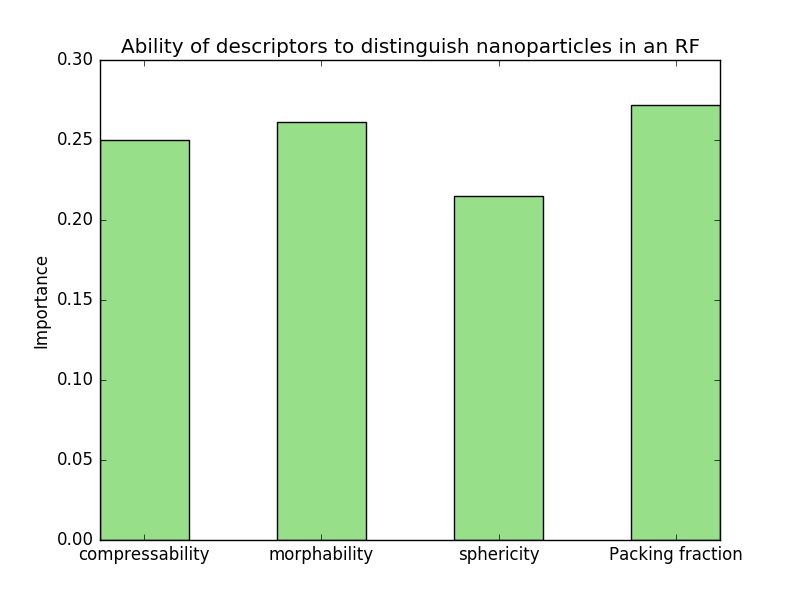

In [41]:
fig, ax = plt.subplots()
rects = ax.bar(np.arange(4),rforests.feature_importances_,width=0.5, color=tableau4_light[1])
ax.set_ylabel('Importance')
ax.set_title('Ability of descriptors to distinguish nanoparticles in an RF')
ax.set_xticks(np.arange(4)+0.25)
ax.set_xticklabels(['compressability','morphability','sphericity','Packing fraction'],rotation=0)

plt.savefig('DescriptorImportance.png',format='png')
Image('DescriptorImportance.png')

No descriptor stands out as being important over the rest.